# Facies classification using Machine Learning

#### Brendon Hall, [Enthought](https://www.enthought.com/)

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a support vector machine to classify facies types.  Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks.  The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case).  We will use the SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/svm.html).

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [build the SVM classifier](#Building-the-SVM-classifier).  We will demonstrate how to use the cross validation set to do [model parameter selection](#Model-parameter-selection).

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)

filename = 'facies_vectors_v2.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,1,Tymen,X8,2889.2,56.782001,17.142700,2.8838,2.4175,275.975586,1,1
1,1,Tymen,X8,2889.3,56.891998,18.186399,2.8778,2.4185,274.548676,1,1
2,1,Tymen,X8,2889.4,57.002003,18.323299,2.8718,2.4165,274.066498,1,1
3,1,Tymen,X8,2889.5,56.931602,17.087601,2.8658,2.4080,273.848816,1,1
4,1,Tymen,X8,2889.6,56.139595,16.321800,2.8582,2.4100,273.531982,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7207,1,Tymen,X17,2931.2,72.523003,-999.250000,12.7220,2.5650,224.800000,1,1
7208,1,Tymen,X17,2931.3,74.228004,-999.250000,13.4780,2.5720,221.670000,1,1
7209,1,Tymen,X17,2931.4,71.478004,-999.250000,13.7530,2.5630,222.130000,1,1
7210,1,Tymen,X17,2931.5,69.982002,-999.250000,13.1690,2.5530,222.580000,1,1


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [66]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['X8', 'X7', 'X11', 'X16', 'X17']
Categories (5, object): ['X8', 'X7', 'X11', 'X16', 'X17']

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [67]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#EEE8AA','#D3D3D3','#7f6464',
       '#00FFFF','#000001']

facies_labels = ['SS', 'SSH', 'SHH', 'SH', 'Tight',
                 'Coal']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,7212.000000,7212.000000,7212.000000,7212.000000,7212.000000,7212.000000,7212.000000,7212.0,7212.0
mean,2.754437,2856.886190,71.893752,10.249928,4.655501,2.452053,274.564350,1.0,1.0
std,1.457963,71.874902,28.065242,79.593077,2.367131,0.178423,34.130963,0.0,0.0
min,1.000000,2722.500000,19.360001,-999.250000,1.294200,1.279000,18.052000,1.0,1.0
25%,2.000000,2802.100000,46.508003,7.724000,3.058000,2.412200,254.197498,1.0,1.0
50%,2.000000,2847.200000,68.738998,9.312200,3.911500,2.474000,269.375702,1.0,1.0
75%,3.000000,2899.525000,92.141502,12.704075,4.985000,2.543000,290.579483,1.0,1.0
max,6.000000,3038.100000,158.554001,2958.539063,15.846000,3.314000,483.450000,1.0,1.0


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [68]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [69]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    t = np.arange(0.01, 20.0, 0.01)
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=7)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((28*' ').join(['SS', 'SSH', 'SHH', 'SH', 'Tight',
                 'Coal']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[1].set_xscale('log')
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("BK")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("NKTB")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("DENS")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("DTP")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('LITH')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN` and `SHANKLE`.  

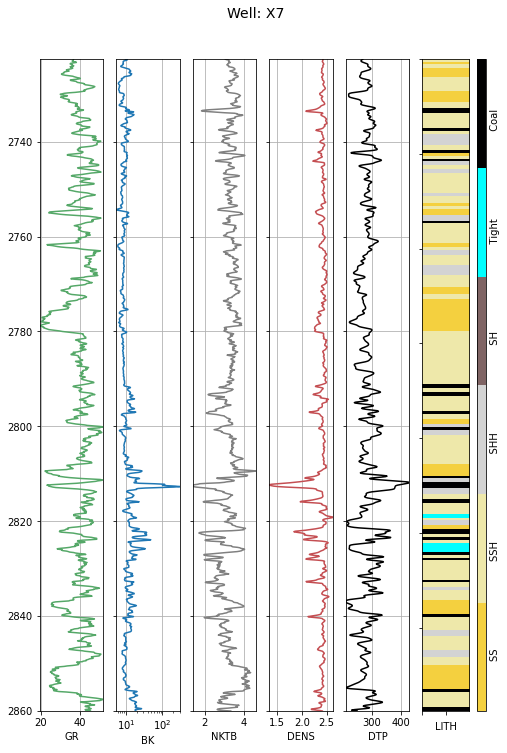

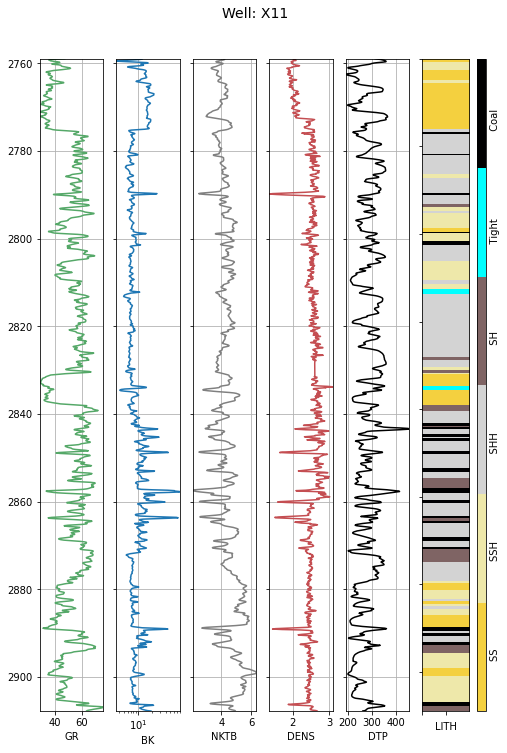

In [70]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'X7'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'X11'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

SS       1173
SSH      2696
SHH      1848
SH        495
Tight     224
Coal      776
Name: Facies, dtype: int64

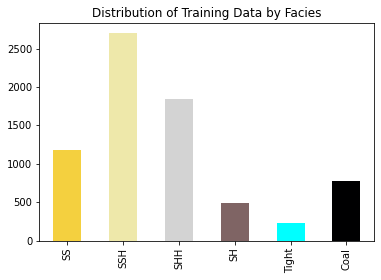

In [71]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the 3232 training examples in the training set.  Dolomite (facies 7) has the fewest with 141 examples.  There are also only 185 bafflestone examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

C:\Users\AladievAP\Miniconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\AladievAP\Miniconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\AladievAP\Miniconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\AladievAP\Miniconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\AladievAP\Miniconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The sa

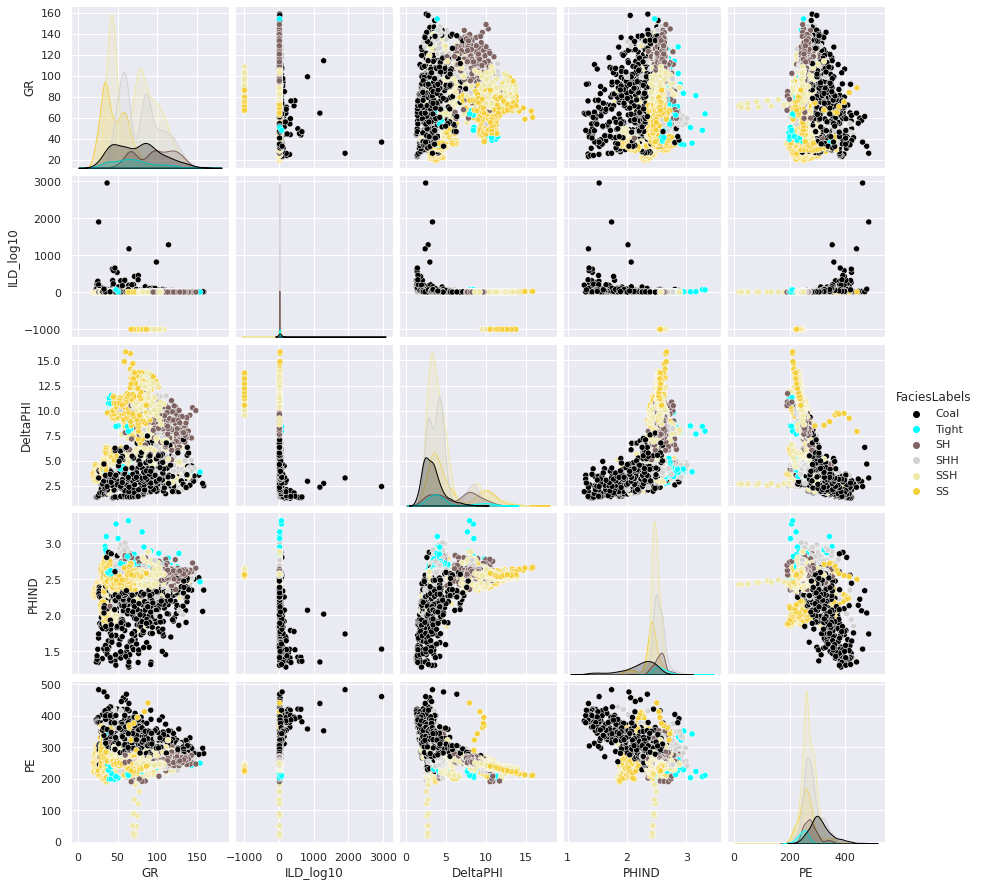

In [72]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [73]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,7212.000000,7212.000000,7212.000000,7212.000000,7212.000000,7212.0,7212.0
mean,71.893752,10.249928,4.655501,2.452053,274.564350,1.0,1.0
std,28.065242,79.593077,2.367131,0.178423,34.130963,0.0,0.0
min,19.360001,-999.250000,1.294200,1.279000,18.052000,1.0,1.0
25%,46.508003,7.724000,3.058000,2.412200,254.197498,1.0,1.0
50%,68.738998,9.312200,3.911500,2.474000,269.375702,1.0,1.0
75%,92.141502,12.704075,4.985000,2.543000,290.579483,1.0,1.0
max,158.554001,2958.539063,15.846000,3.314000,483.450000,1.0,1.0


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [74]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Training the SVM classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).  The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.  

The SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) takes a number of important parameters.  First we create a classifier using the default settings.  

In [76]:
from sklearn import svm

clf = svm.SVC()

Now we can train the classifier using the training set we created above.

In [77]:
clf.fit(X_train,y_train)

SVC()

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [78]:
predicted_labels = clf.predict(X_test)

# We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [79]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

   SS
  SSH
  SHH
   SH
Tight
 Coal
Total
     True
       SS
  139
   75
    1
     
     
    2
  217
      SSH
   27
  419
   83
     
     
   10
  539
      SHH
    3
  135
  234
    4
     
   12
  388
       SH
     
   23
   52
   36
     
    1
  112
    Tight
    8
   20
   14
     
    1
     
   43
     Coal
    9
   28
   17
     
     
   90
  144
Precision
 0.75
 0.60
 0.58
 0.90
 1.00
 0.78
 0.67
   Recall
 0.64
 0.78
 0.60
 0.32
 0.02
 0.62
 0.64
       F1
 0.69
 0.68
 0.59
 0.47
 0.05
 0.69
 0.62


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [80]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [81]:
adjacent_facies = np.array([[1,2], [2], [1], [2,3], [3], [4,5], [5], [6]], dtype=object)

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [82]:
print ('Facies classification accuracy = %f' % accuracy(conf))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.636868
Adjacent facies classification accuracy = 0.963964


## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

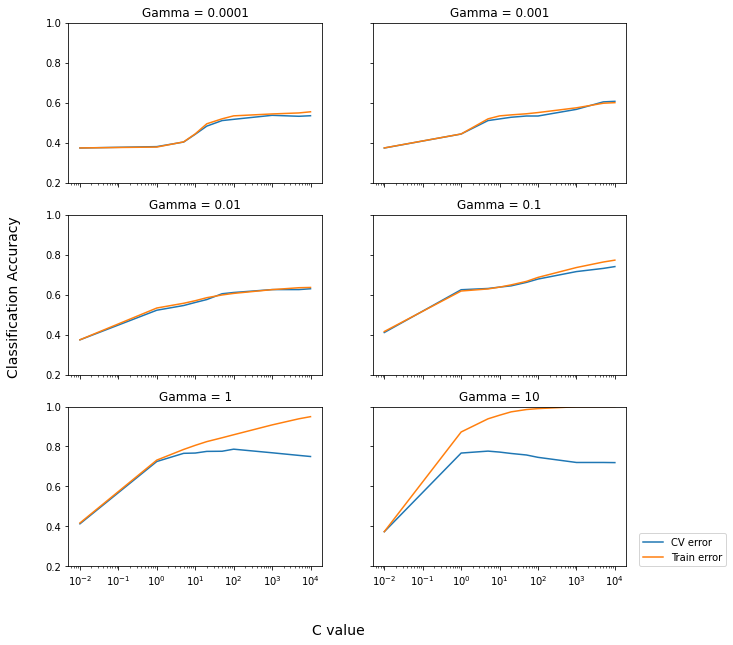

In [83]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = plot_number // 2
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

In [84]:
clf = svm.SVC(C = 10, gamma = 10)        
clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print ('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print ('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.77
Optimized adjacent facies classification accuracy = 1.00


[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are metrics that give more insight into how the classifier performs for individual facies.  Precision is the probability that given a classification result for a sample, the sample actually belongs to that class.  Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix.  The code to do so has been added to the `display_confusion_matrix()` function:

In [85]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

   SS
  SSH
  SHH
   SH
Tight
 Coal
Total
     True
       SS
  186
   22
    1
     
    1
    7
  217
      SSH
   13
  459
   41
    3
    3
   20
  539
      SHH
    5
   77
  277
   10
    4
   15
  388
       SH
    2
    9
   18
   75
    1
    7
  112
    Tight
    2
    7
    5
    1
   20
    8
   43
     Coal
    5
   27
   15
     
     
   97
  144
Precision
 0.87
 0.76
 0.78
 0.84
 0.69
 0.63
 0.77
   Recall
 0.86
 0.85
 0.71
 0.67
 0.47
 0.67
 0.77
       F1
 0.87
 0.81
 0.74
 0.75
 0.56
 0.65
 0.77


To interpret these results, consider facies `SS`.  In our test set, if a sample was labeled `SS` the probability the sample was correct is 0.8 (precision).  If we know a sample has facies `SS`, then the probability it will be correctly labeled by the classifier is 0.78 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The [F1 score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results.  For example, for a sample with facies `MS` or mudstone, it is only classified correctly 57% of the time (recall).  Perhaps this could be improved by introducing more training samples.  Sample quality could also play a role.  Facies `BS` or bafflestone has the best `F1` score and relatively few training examples.  But this data was handpicked from other wells to provide training examples to identify this facies.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:


In [86]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

   SS
  SSH
  SHH
   SH
Tight
 Coal
Total
     True
       SS
  209
     
     
     
    1
    7
  217
      SSH
   13
  500
     
    3
    3
   20
  539
      SHH
    5
     
  354
   10
    4
   15
  388
       SH
    2
    9
     
     
    1
    7
   19
    Tight
    2
    7
    5
     
   21
    8
   43
     Coal
    5
   27
   15
     
     
     
   47
Precision
 0.89
 0.92
 0.95
 0.00
 0.70
 0.00
 0.87
   Recall
 0.96
 0.93
 0.91
 0.00
 0.49
 0.00
 0.87
       F1
 0.92
 0.92
 0.93
 0.00
 0.58
 0.00
 0.86


Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying `SiSh` or marine siltstone and shale.  The classifier often misclassifies this facies (recall of 0.66), most often as wackestone. 

These results are comparable to those reported in Dubois et al. (2007).

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [98]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [99]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [100]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,Tymen,X17,2786.5,94.269997,6.513,8.511,2.611,262.090,1,1,3
1,Tymen,X17,2786.6,83.567001,5.084,8.148,2.674,264.680,1,1,2
2,Tymen,X17,2786.7,83.225998,5.087,7.846,2.632,267.250,1,1,2
3,Tymen,X17,2786.8,95.887001,5.258,7.790,2.561,273.640,1,1,2
4,Tymen,X17,2786.9,106.084000,5.969,7.400,2.577,280.010,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
4381,Tymen,X22,3153.2,104.478000,13.543,8.154,2.553,261.249,1,1,2
4382,Tymen,X22,3153.3,104.620990,13.809,8.033,2.551,261.249,1,1,2
4383,Tymen,X22,3153.4,104.918000,14.075,7.784,2.644,269.633,1,1,3
4384,Tymen,X22,3153.5,105.325000,13.854,7.772,2.702,269.633,1,1,6


In [101]:
well_data['Well Name'].unique()

['X17', 'X8', 'X22']
Categories (3, object): ['X17', 'X8', 'X22']

We can use the well log plot to view the classification results along with the well logs.

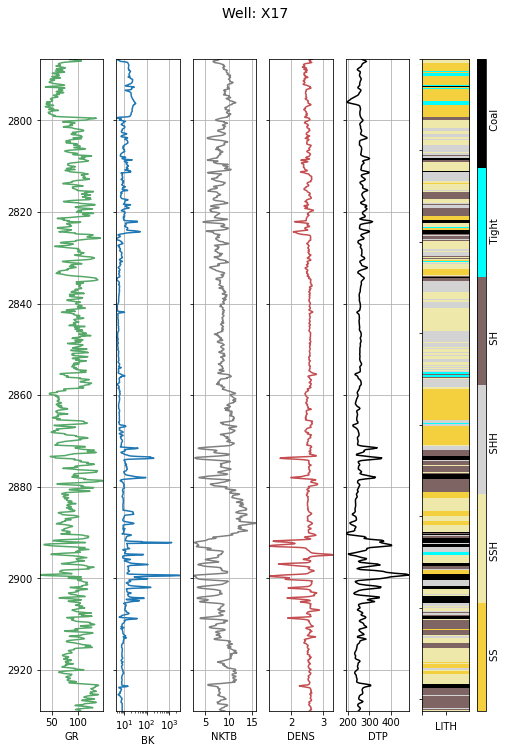

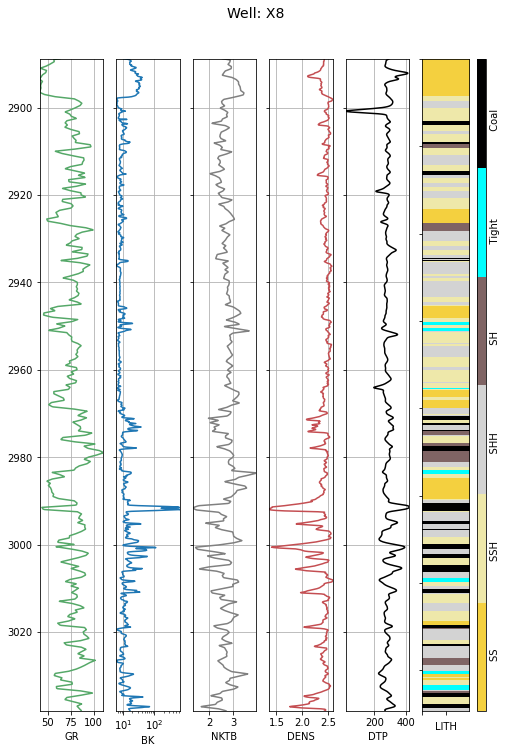

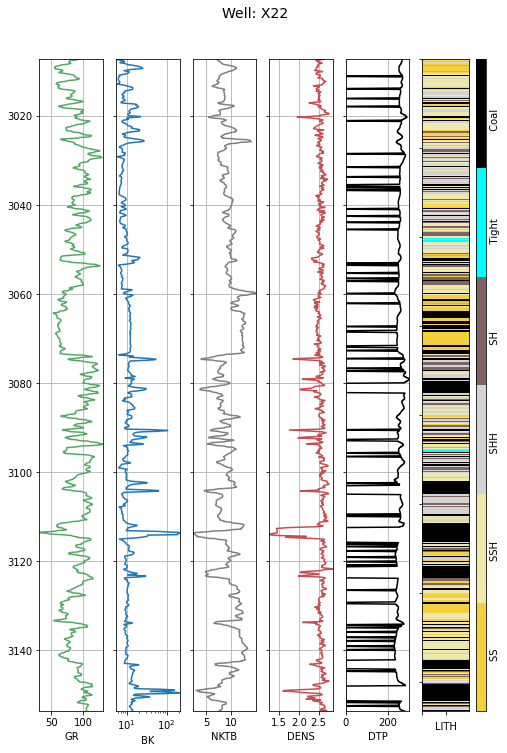

In [102]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'X17'],
    facies_colors=facies_colors)
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'X8'],
    facies_colors=facies_colors)
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'X22'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [92]:
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)